In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Understanding Autodiff with Micrograd

In [2]:
# Sample function

def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
print(f(3.0))

20.0


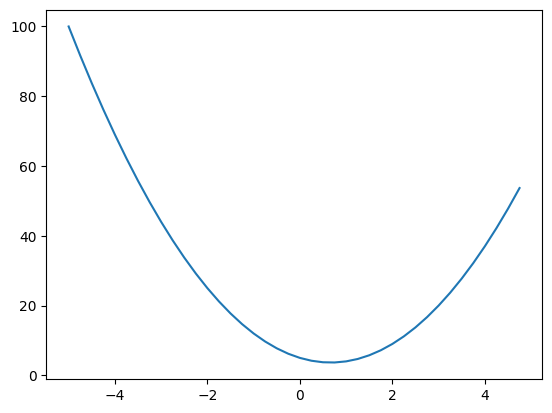

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
# Positive slope

h = 0.00000001
x = 3.0
(f(x + h) - f(x)) / h

14.00000009255109

In [6]:
# Negative slope

x = -3.0
(f(x + h) - f(x)) / h

-22.00000039920269

In [7]:
# Zero slope

x = 2/3
(f(x + h) - f(x)) / h

0.0

In [8]:
# Now for more complex functions

a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [9]:
# Let's find the slope of d with respect to a by increasing a by a small amount h

h = 0.0001

# Inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1',d1)
print('d2',d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [10]:
# Let's find the slope of d with respect to a by increasing a by a small amount h

h = 0.0001

# Inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print('d1',d1)
print('d2',d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [11]:
# Let's find the slope of d with respect to a by increasing a by a small amount h

h = 0.0001

# Inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1',d1)
print('d2',d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


# let's build a Value class to represent a single scalar value, and the operations that can be performed on it

In [12]:
# Let's make a value class

class Value:

    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self,other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
    # def exp(self):
    #     out = Value(math.exp(self.data), (self,), 'exp')
    #     return out

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(t, (self,), 'tanh')
        return out

a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d*f; L.label = 'L'

## Creating Computational Graphs

In [13]:
from graphviz import Digraph

def trace(root):
    # Builds sets of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build_graph(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build_graph(child)
    build_graph(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR here means left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # For any value in graph create a rectangular ('record') node for it
        dot.node(name = uid, label = f"{{ {n.label} | data: {n.data:.4f} | grad: {n.grad:.4f} }}", shape='record')
        if n._op:
            # If this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect it to this value node
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connec n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

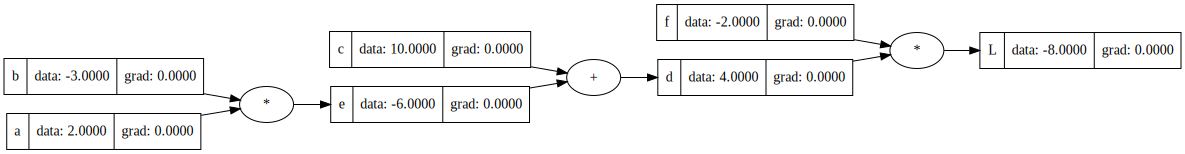

In [14]:
draw_dot(L)

# Manually finding & setting gradients wrt output node

### **A slight demonstration of the chain rule in action when calculating gradients**

Here is a simple breakdown of the chain rule applied to a computational graph:

$ \frac{\partial L}{\partial d} = f $

$ \frac{\partial d}{\partial e} = 1 $

$ \frac{\partial d}{\partial c} = 1 $

Therefore,
$ \frac{\partial L}{\partial e} = \frac{\partial L}{\partial d} \cdot \frac{\partial d}{\partial e} = f \cdot 1 = f $

$ \frac{\partial L}{\partial c} = \frac{\partial L}{\partial d} \cdot \frac{\partial d}{\partial c} = f \cdot 1 = f $

In [15]:
# Setting the found gradient values wrt output node (L)

L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
e.grad = -2.0
c.grad = -2.0
a.grad = 6.0 # since b = -3.0, and de/da = b and de/da * dL/de = -3 * -2 = 6
b.grad = -4.0 # since a = 2.0, and de/db = a and de/db * dL/de = 2 * -2 = -4

In [16]:
# Manually checking gradients of L wrt a, b, c, d, f, brrr function is to just keep the variables local in scope
# one by one we go backwards and set the gradients by adding h to each variable and seeing how much L changes

def brrr():
    h = 0.0001

    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d*f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label = 'a')
    a.data += h
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d*f; L.label = 'L'
    L2 = L.data

    print('grad wrt a', (L2 - L1)/h)
    
brrr()

grad wrt a 6.000000000021544


# Taking a step further and seeing what Neurons and activation functions look like

Let's see how a biologically inspired neuron works. A neuron takes multiple inputs, applies weights to them, adds a bias, and then passes the result through a non-linear activation function (like tanh).

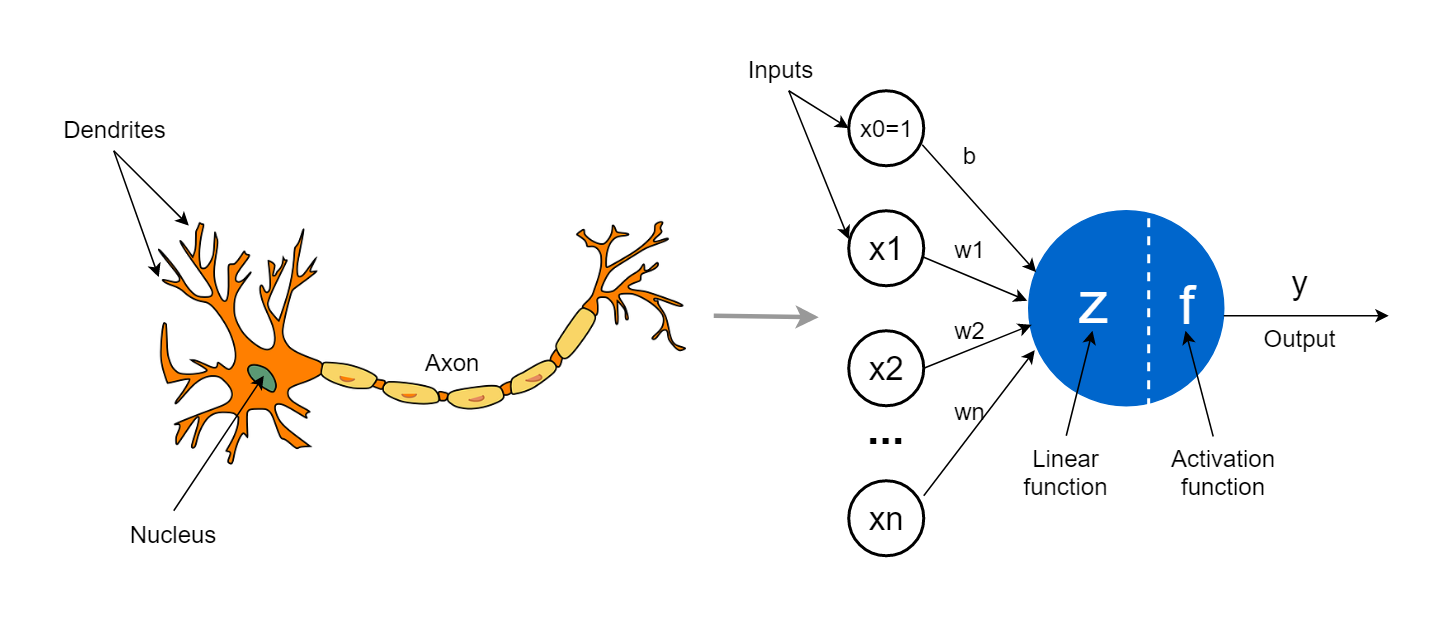

Shown above is a simple neuron with n inputs. The output of the neuron is given after applying the activation function to the weighted sum of inputs plus bias.

the bias term can be thought of as a x0 input with a constant value of 1.0 and a weight equal to the bias.

Weights are the synaptic strengths in a biological neuron, determining how much influence each input has on the output. While the bias is the trigger happiness level of the neuron, determining the threshold at which the neuron activates.

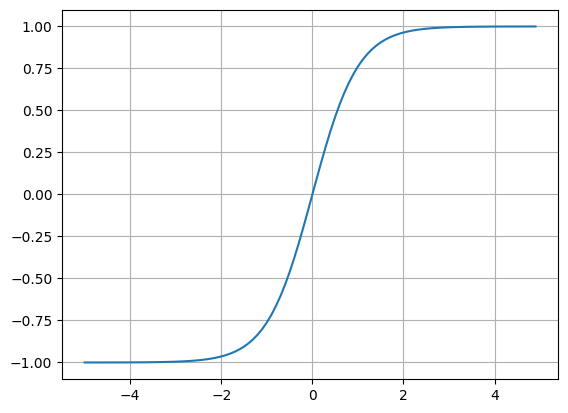

In [17]:
# Visualizing tanh activation function's squashing property with output range [-1, 1]

plt.plot(np.arange(-5,5,0.1), np.tanh(np.arange(-5,5,0.1)))
plt.grid()

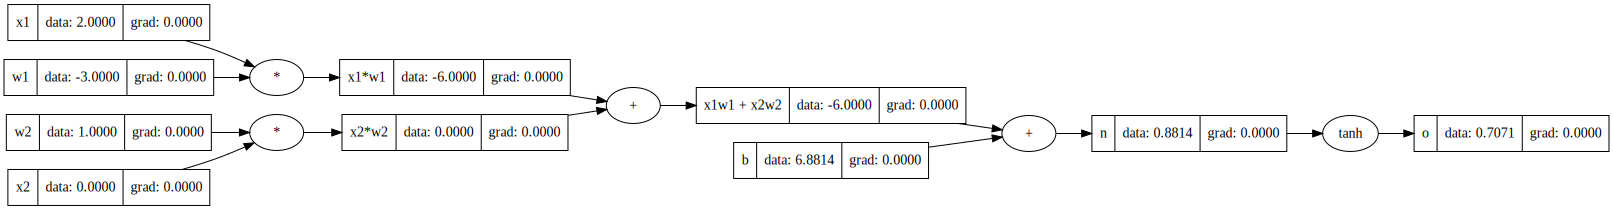

In [18]:
# inputs of the neuron: x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of the neuron: w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron: b
b = Value(6.8813735870195432, label='b') # bias is set to 6.8813735870195432 to get output close to 1.0

# x1*w1 + x2*w2 + b (step by step)
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# applying activation function of tanh
o = n.tanh(); o.label = 'o'

draw_dot(o)

## Applying activation function and finding gradients manually

And as we know, the derivative of tahn is:

$ \frac{dtanh(x)}{dx} = 1 - \tanh^2(x) $
 
 So we can set the gradient of $ o $ with respect to $ n $ as follows:

In [19]:
# since tanh(n) = o
o.data

0.7071067811865476

In [20]:
# n.grad = 1 - o.data**2
dodn = 1 - o.data**2
dodn   

0.4999999999999999

In [21]:
# Therfore, n.grad = dodn * o.grad
o.grad = 1.0
n.grad = 0.5 * 1.0

In [22]:
# Gradients of the b and x1w1 + x2w2 are the same as they are added together

x1w1x2w2.grad = 0.5
b.grad = 0.5

In [23]:
# Similarily, the gradients of x1w1 and x2w2 are the same as they are added together

x1w1.grad = 0.5
x2w2.grad = 0.5

In [24]:
# Applying the chain rule to get gradients of x2 and w2

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [25]:
# Applying the chain rule to get gradients of x1 and w1

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

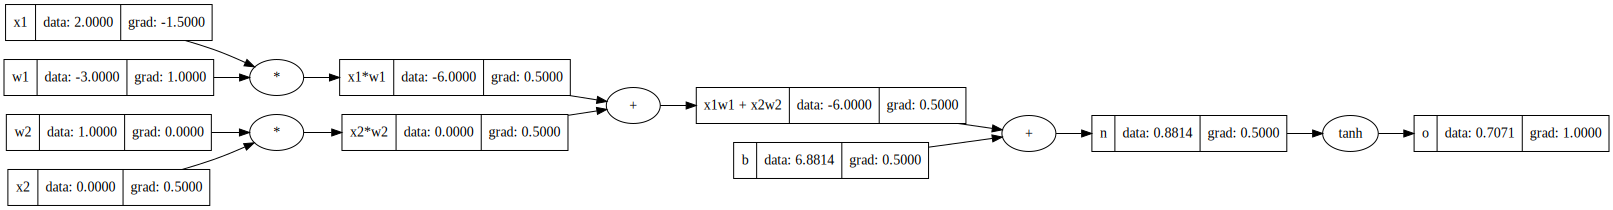

In [26]:
draw_dot(o)

# But doing this manually is tedious and error-prone.

#### Let's see how we can automate this process by making some changes in our Value class to support automatic differentiation.

In [27]:
# Let's make a value class that supports automatic differentiation

class Value:

    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # by default, do nothing
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad

        out._backward = _backward # No parentheses here, we are assigning the function, not calling it
        return out

    def __mul__(self,other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

        out._backward = _backward # No parentheses here, we are assigning the function, not calling it
        return out
    
    # def exp(self):
    #     out = Value(math.exp(self.data), (self,), 'exp')
    #     return out

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad = (1-t**2) * out.grad

        out._backward = _backward # No parentheses here, we are assigning the function, not calling it

        return out

In [28]:
# Redefining the neuron to check automatic differentiation

# inputs of the neuron: x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of the neuron: w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron: b
b = Value(6.8813735870195432, label='b') # bias is set to 6.8813735870195432 to get output close to 1.0

# x1*w1 + x2*w2 + b (step by step)
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# applying activation function of tanh
o = n.tanh(); o.label = 'o'

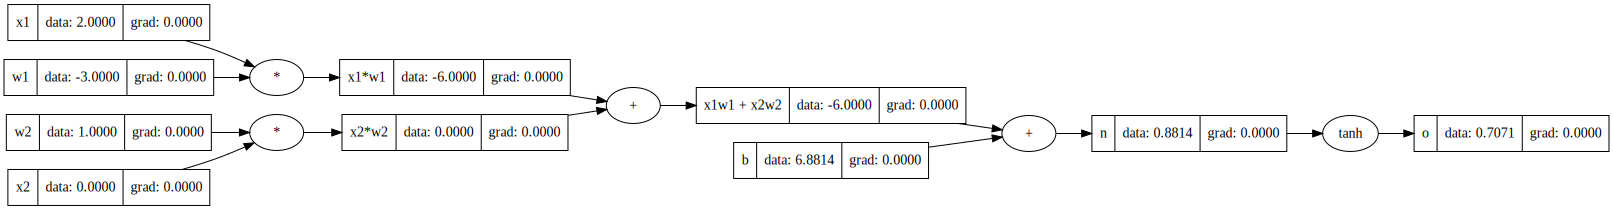

In [29]:
# The grads are all zeroes before backpropagation

draw_dot(o)

In [30]:
# Setting the gradient of output node to 1 as base case for backpropagation

o.grad = 1.0

In [31]:
# Going backwards in the graphical order (right-to-left) to get all the gradients calculated

o._backward()
n._backward()
x1w1x2w2._backward()
b._backward()
x2w2._backward()
x1w1._backward()
w2._backward()
w1._backward()
x2._backward()
x1._backward()

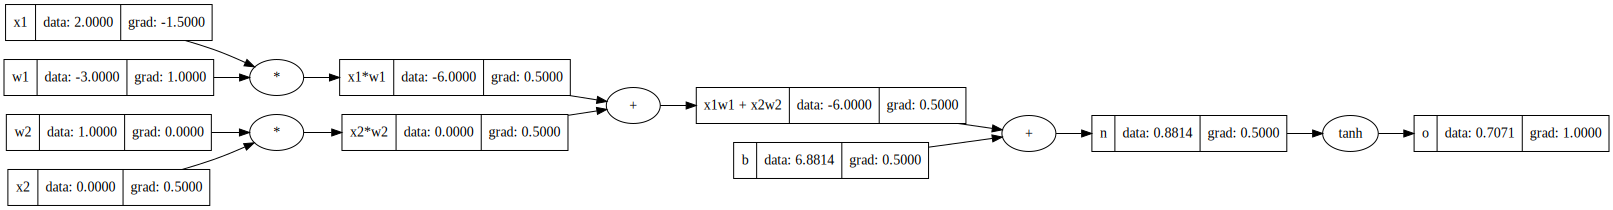

In [32]:
# All the gradients are calculated automatically after backpropagation

draw_dot(o)

# Now for the Final Piece

We need to make it so that we don't need to manually call "_backward" on each node. Instead, we want to call "backward" on the output node, and have it automatically traverse the graph in reverse order, calling "_backward" on each node.

We can do this by performing a topological sort of the nodes in the graph, and then calling "_backward" on each node in reverse order.

In [33]:
# Defining the topological sort function

# commenting this out and adding the build_topo function to the value class itself

# topo = []
# visited = set()
# def build_topo(v):
#     if v not in visited:
#         visited.add(v)
#         for child in v._prev:
#             build_topo(child)
#         topo.append(v)

In [34]:
# build_topo(o)
# topo

In [35]:
# The new and improved Value class with build_topo function and a new backward function

# Let's make a value class that supports automatic differentiation without manual backward calls

class Value:

    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # by default, do nothing
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad

        out._backward = _backward # No parentheses here, we are assigning the function, not calling it
        return out

    def __mul__(self,other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

        out._backward = _backward # No parentheses here, we are assigning the function, not calling it
        return out
    
    # def exp(self):
    #     out = Value(math.exp(self.data), (self,), 'exp')
    #     return out

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad = (1-t**2) * out.grad

        out._backward = _backward # No parentheses here, we are assigning the function, not calling it
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [36]:
# Redefining the neuron to check automatic differentiation

# inputs of the neuron: x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of the neuron: w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron: b
b = Value(6.8813735870195432, label='b') # bias is set to 6.8813735870195432 to get output close to 1.0

# x1*w1 + x2*w2 + b (step by step)
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# applying activation function of tanh
o = n.tanh(); o.label = 'o'

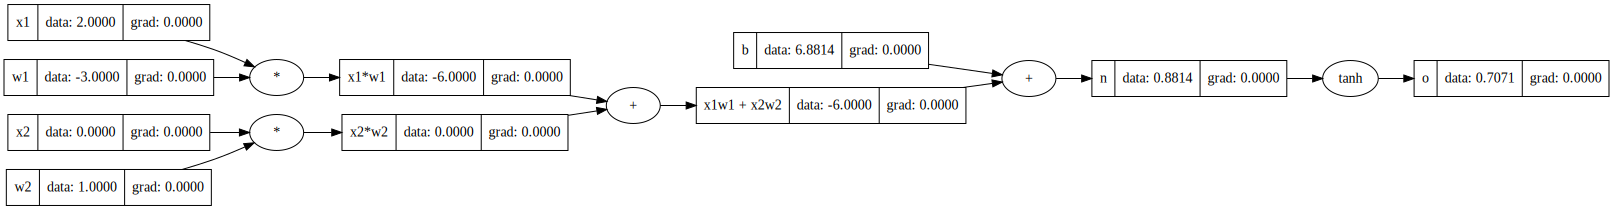

In [37]:
# see the complete graph with all the nodes and edges without any gradients calculated yet
draw_dot(o)

In [38]:
# Now, with just one backward call, all the gradients are calculated automatically
o.backward()

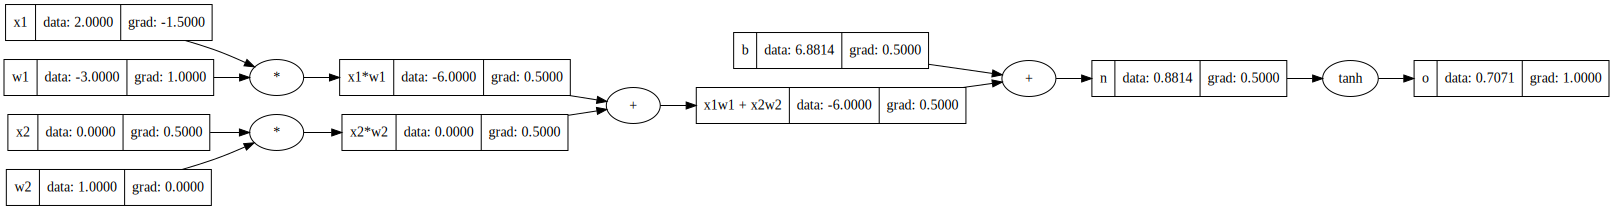

In [39]:
draw_dot(o)

## At this point we still have a yet unseen Bug

Let's see what that bud actually is.

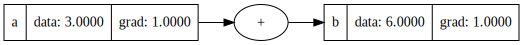

In [40]:
# Let's look at a case like this:

a = Value(3.0, label='a')
b = a + a; b.label = 'b'

b.backward()
draw_dot(b)

The gradient for a here should be 2.0, because the output b is a + a, so db/da = 2.0. But if we run the code, we see that the gradient for a is 1.0.

The Bug appears whenever a single variable is used multiple times in the computation of the output. 

Let's look at a more complex example:

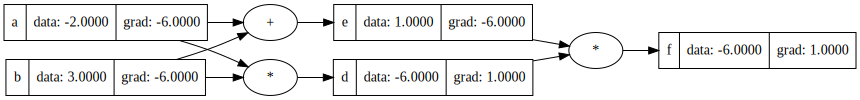

In [41]:
# This is the more complex case we'll be looking at

a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()
draw_dot(f)

Did you spot it?

Whenever a single variable is used multiple times in the computation of the output, the gradient of that variable ends up being incorrect.

The issue is that in the dunder add ( _ _ add_ _ ) and dunder mul ( _ _ mul_ _ ) method, we are using "=" to set the gradients of self and other, and what that does is for multiple additions of the same node, it overwrites the gradient instead of accumulating it.

Can you think of a fix? Well here is how we can fix it:

instead of using =, we can use += to accumulate the gradients. Like:

for dunder add:
```python
self.grad += 1.0 * out.grad
other.grad += 1.0 * out.grad
```

for dunder mul:
```python
self.grad += other.data * out.grad
other.grad += self.data * out.grad
```

In [42]:
# So our Bug free Value class looks like this

class Value:

    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # by default, do nothing
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad              # changed from = to += for grad accumulation
            other.grad += 1.0 * out.grad             # changed from = to += for grad accumulation

        out._backward = _backward 
        return out
    
    def __mul__(self,other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad      # changed from = to += for grad accumulation
            other.grad += self.data * out.grad      # changed from = to += for grad accumulation

        out._backward = _backward 
        return out
    
    # def exp(self):
    #     out = Value(math.exp(self.data), (self,), 'exp')
    #     return out

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad        # changed from = to += for grad accumulation

        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

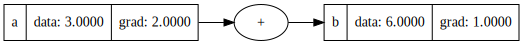

In [43]:
# Now let's again look at the conflicting case where a value is used more than once in the graph

a = Value(3.0, label='a')
b = a + a; b.label = 'b'

b.backward()
draw_dot(b)

As you can see, the gradient of 'a' is now correctly calculated as 2.0, which is the sum of the gradients from both paths in the computation graph. Just by gradient accumulation we were able to fix the bug.

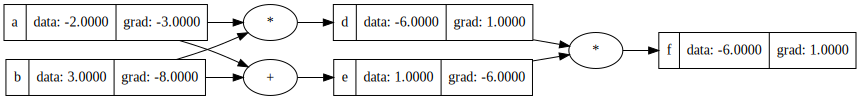

In [44]:
# Also the more complex case

a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()
draw_dot(f)

Here also now we can see that the gradient of recurring variables is now correctly calculated.

# Let's See how this works Using Libraries like PyTorch

In [48]:
import torch

print(f"Is CUDA available? {torch.cuda.is_available()}")
print(f"CUDA Version: {torch.version.cuda}")
print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")

Is CUDA available? True
CUDA Version: 13.0
CUDA Device Name: NVIDIA GeForce RTX 4070 Laptop GPU


In [ ]:
# Redefining the neuron to check automatic differentiation in PyTorch

# Doing double precision to match python's precision with Float64
x1 = torch.Tensor([2.0]).double()                  ; x1.requires_grad_(True)
x2 = torch.Tensor([0.0]).double()                  ; x2.requires_grad_(True)
w1 = torch.Tensor([-3.0]).double()                 ; w1.requires_grad_(True)
w2 = torch.Tensor([1.0]).double()                  ; w2.requires_grad_(True)
b = torch.Tensor([6.8813735870195432]).double()    ; b.requires_grad_(True)
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item()) # o.item and o.data.item() both work the same here in pytorch
o.backward()

print('------')
print("x1's grad", x1.grad.item())
print("x2's grad", x2.grad.item())
print("w1's grad", w1.grad.item())
print("w2's grad", w2.grad.item())

0.7071066904050358
------
x1's grad -1.5000003851533106
x2's grad 0.5000001283844369
w1's grad 1.0000002567688737
w2's grad 0.0


So as we can see, the output is the same as what we got using our micrograd implementation. And if we check the gradients, we can see that they are also the same.

Our micrograd implementation is just a simplified version of what PyTorch does under the hood. PyTorch has a lot more features and optimizations, but the basic idea is the same, while our micrograd version only operates on singular scalar values, PyTorch can handle multi-dimensional tensors and has a lot more operations and functionalities.